In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from Bio import Phylo
from Bio.Cluster import treecluster
from Bio.Phylo import Consensus
import os
import ujson
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
from TreeConstructor import upgma, nj


#### Convert distance matrix in NumPy array to a Bio.Phylo.TreeConstruction.DistanceMatrix object

In [2]:
from Bio.Phylo.TreeConstruction import DistanceMatrix

def phylo_dmatrix_from_numpy(labels, distance_mat):
    dist_list = []
    for i in range(distance_mat.shape[0]):
        nested = []
        for j in range(i + 1):
            nested.append(distance_mat[i, j])
            pass

        dist_list.append(nested)
        pass

    phylo_dmatrix = DistanceMatrix(labels, matrix=dist_list)
    return phylo_dmatrix

### Distance Function

In [37]:
def d1(similarity: np.ndarray, r: float =1.05) -> np.ndarray:
    similarity = similarity.copy()
    np.fill_diagonal(similarity, 0)
    ret = 1/np.power(r, similarity)
    np.fill_diagonal(ret, 0)
    return ret

### Obtain all the distance matrices from different datasets

In [4]:
data_dir = "../data/"
f_collab_distance = os.path.join(data_dir, "collaboration_distances.csv")
df_collab_distance = pd.read_csv(f_collab_distance)
faculties = list(df_collab_distance.columns)    # Obtain a list of facauty names
faculties.pop(0)
num_ppl = len(faculties)
pass

In [5]:
dmatrices = []    # List of distance matrices

In [92]:
# Joint Publication

f_joint_pub = os.path.join(data_dir, "joint_publication.json")
with open(f_joint_pub) as file:
    d_joint_pub = ujson.load(file)
    pass

sim_joint_pub = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_pub.items():
    sim_joint_pub[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_pub += sim_joint_pub.T


# Directed Citation
f_dir_cite = os.path.join(data_dir, "citation_directed.json")
with open(f_dir_cite) as file:
    d_dir_cite = ujson.load(file)
    pass

sim_dir_cite = np.zeros((num_ppl, num_ppl))
i = 0
j = 0
for key, val in d_dir_cite.items():
    sim_dir_cite[i, j] = val
    
    j += 1
    if j == num_ppl:
        i += 1
        j = 0
        pass
    pass

sim_dir_cite += sim_dir_cite.T


weight_pub = 2
weight_cite = 1

weight_pub /= weight_pub + weight_cite
weight_cite /= weight_pub + weight_cite

sim_pub_cite = weight_pub * sim_joint_pub + weight_cite * sim_dir_cite

dist_pub_cite = d1(sim_pub_cite)
dist_pub = d1(sim_joint_pub, r=1.5)
dist_cite = d1(sim_dir_cite)
dmatrices.append(dist_pub_cite)

In [93]:
f_joint_cite = os.path.join(data_dir, "citation_joint.json")
with open(f_joint_cite) as file:
    d_joint_cite = ujson.load(file)
    pass

sim_joint_cite = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_cite.items():
    sim_joint_cite[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_cite += sim_joint_cite.T

dist_joint_cite = d1(sim_joint_cite)
dmatrices.append(dist_joint_cite)

In [95]:
f_com_journal = os.path.join(data_dir, "common_journals_.csv")
df_com_journals = pd.read_csv(f_com_journal)
sim_com_journals = df_com_journals[faculties].to_numpy()

dist_com_journals = d1(sim_com_journals)
dmatrices.append(dist_com_journals)

In [96]:
f_com_ref = os.path.join(data_dir, "common_references_.csv")
df_com_ref = pd.read_csv(f_com_ref)
sim_com_ref = df_com_ref[faculties].to_numpy()

dist_com_ref = d1(sim_com_ref)
dmatrices.append(dist_com_ref)

### Convert all the numpy distance matrices to phylo DistanceMatrix objects

In [10]:
phylo_dmatrices = []

for dmat in dmatrices:
    phylo_dmatrices.append(phylo_dmatrix_from_numpy(faculties, dmat))


### Construct phylo trees

In [11]:
phylo_trees = []

for dmat in phylo_dmatrices:
    phylo_trees.append(upgma(dmat))


### Consensus tree

In [209]:
consensus_tree = Consensus.majority_consensus(phylo_trees, cutoff=0.3)

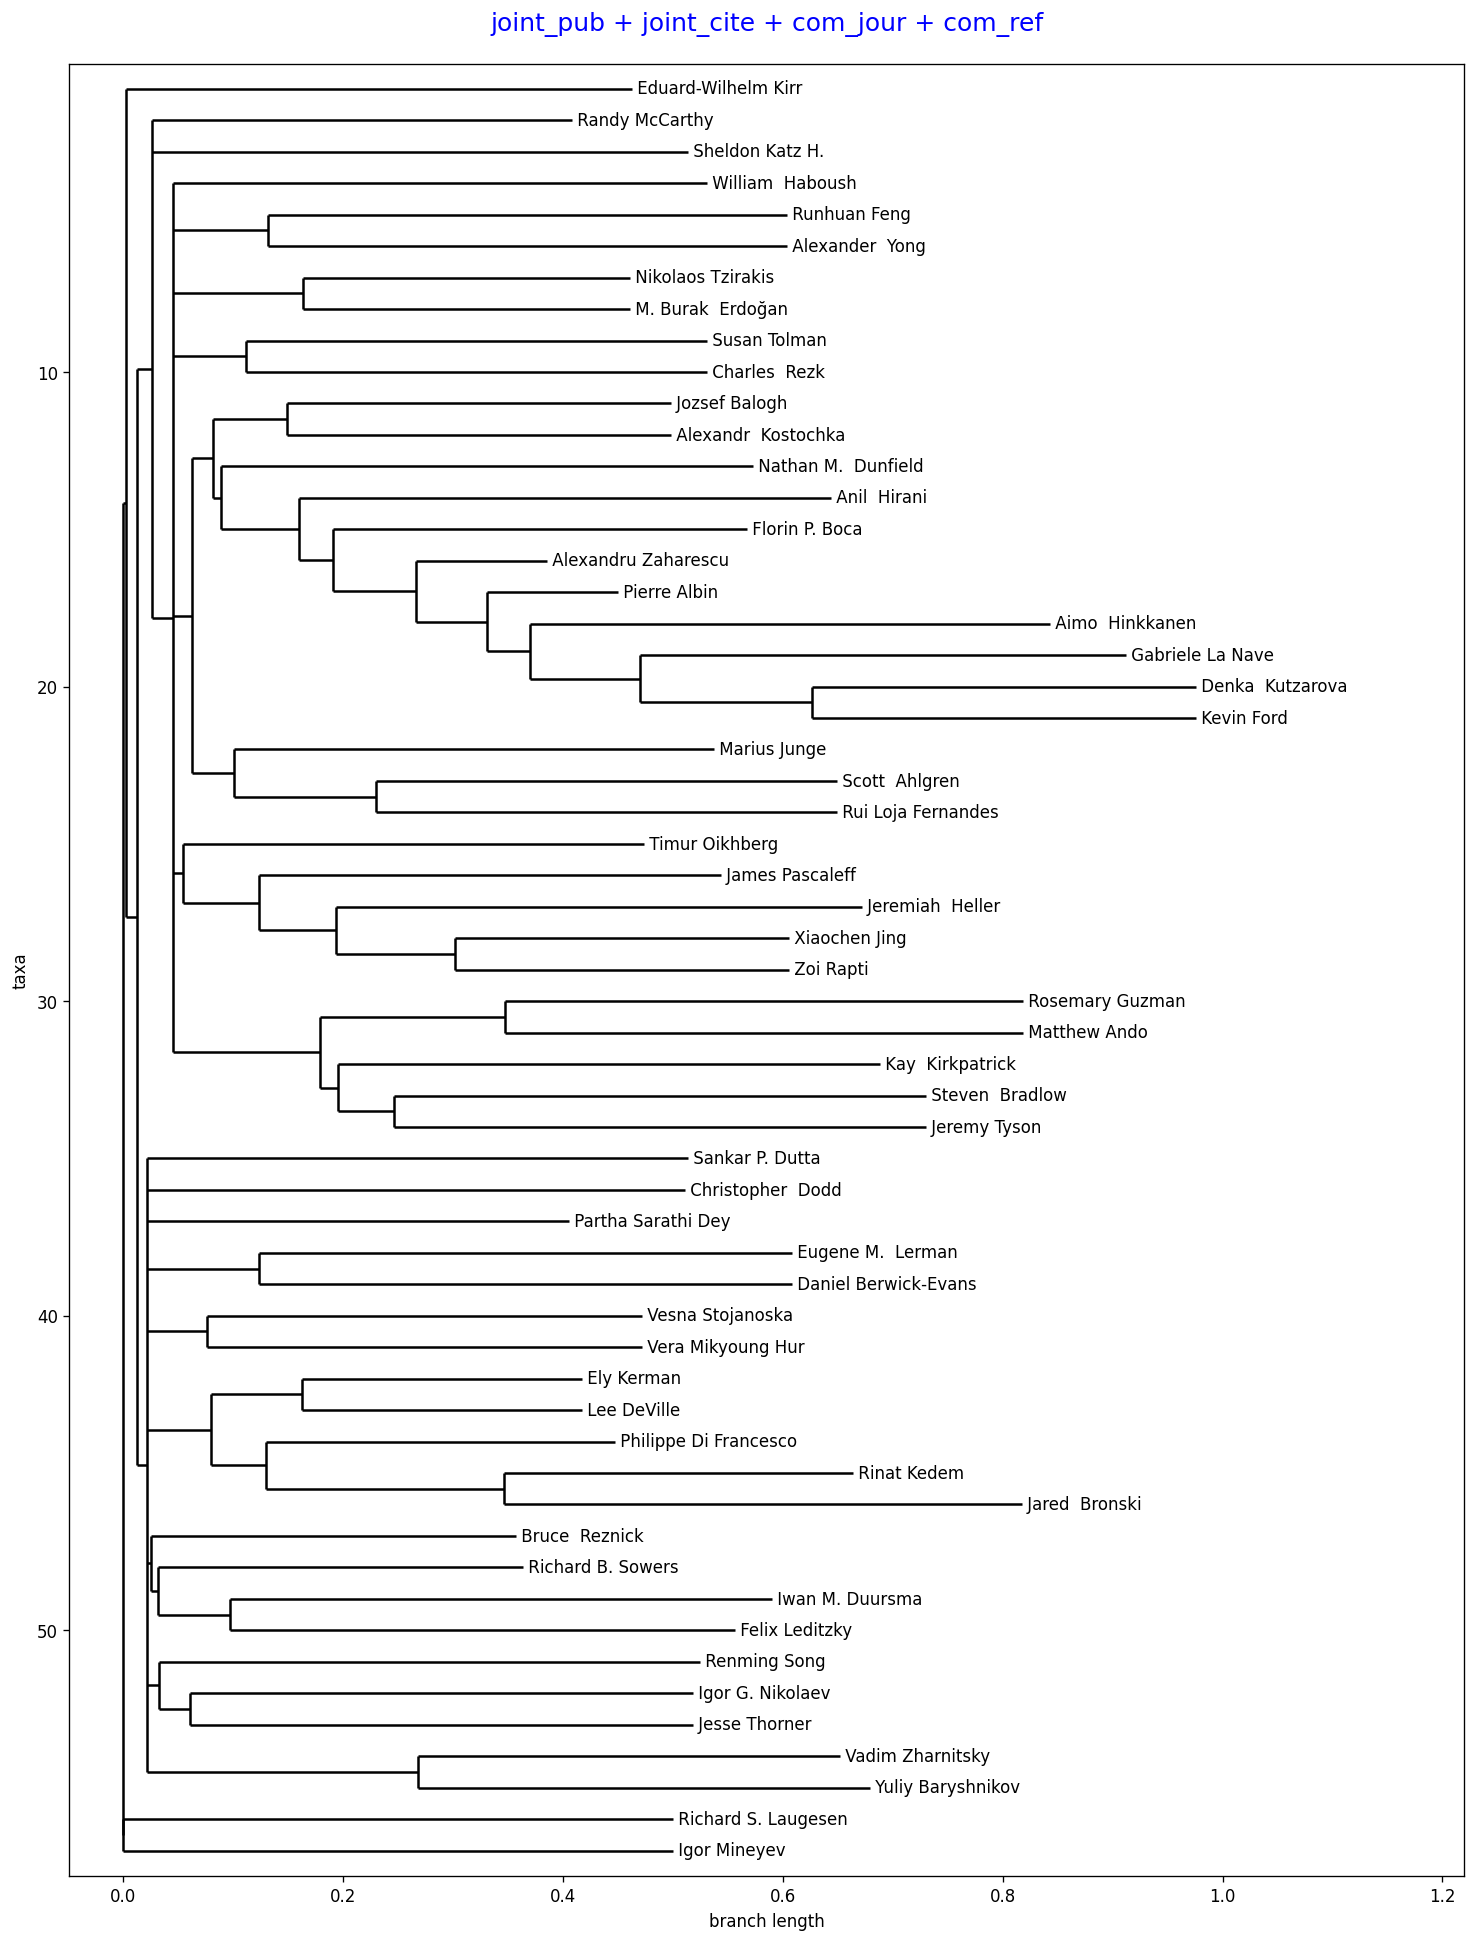

In [211]:
fig = plt.figure(figsize=(15, 20), dpi=120)
axes = fig.add_subplot(1, 1, 1)
fontdic = {'fontsize': 15, 'color':  'blue'}
axes.set_title("joint_pub + joint_cite + com_jour + com_ref", fontdict=fontdic, pad=20)
Phylo.draw(consensus_tree, axes=axes, show_confidence=False, do_show=False)
# plt.savefig("tree_images/consensus_jpdc-jc-cj-cr.png")

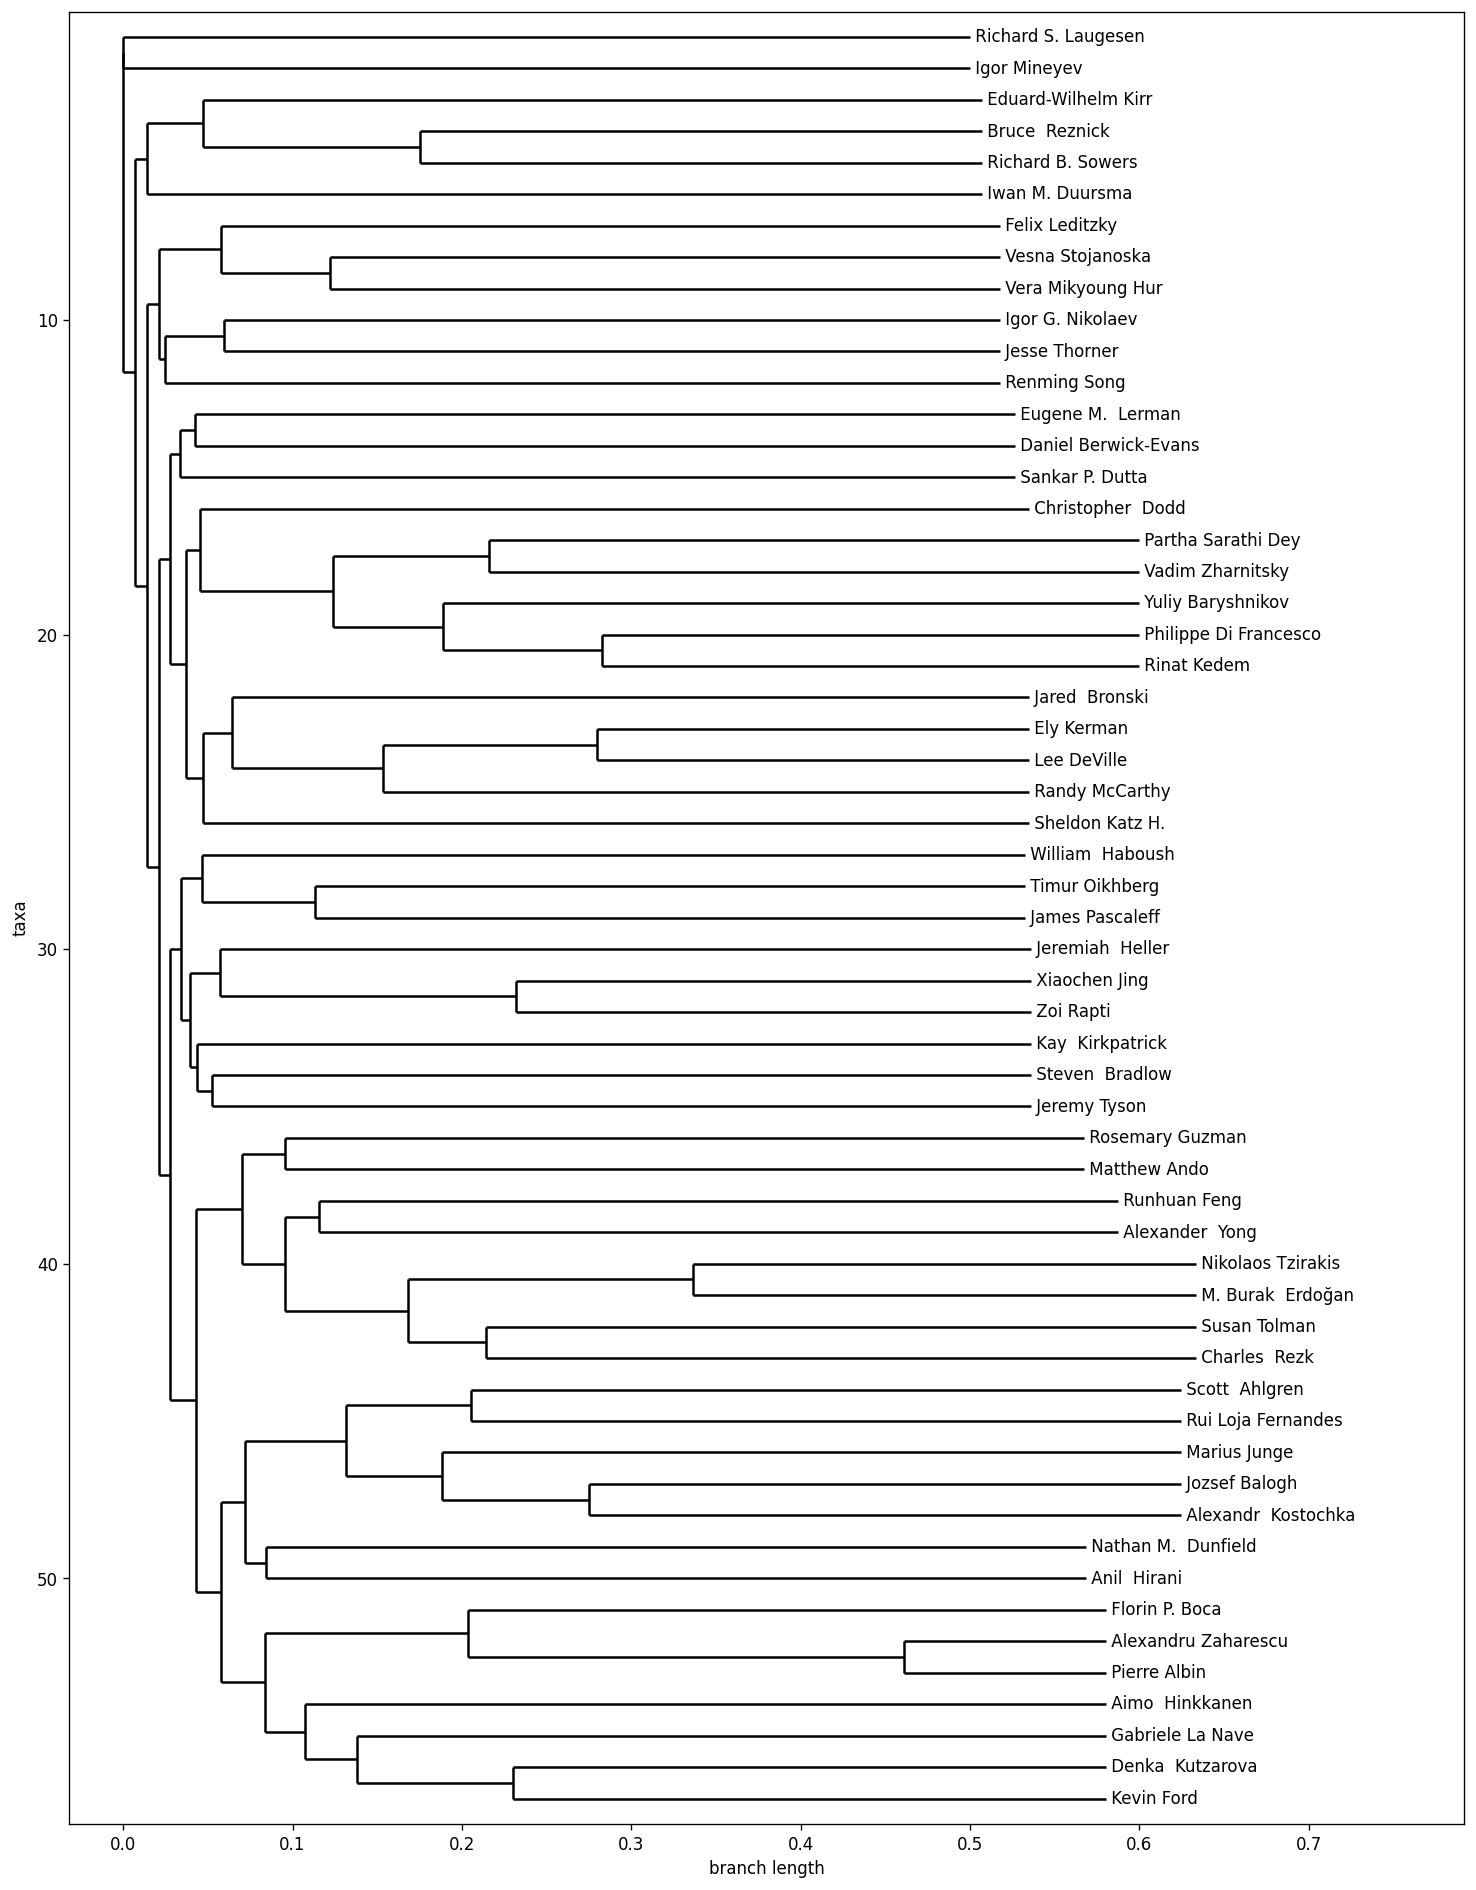

In [200]:
i = 0
for tree in phylo_trees:
    fig = plt.figure(figsize=(15, 20), dpi=120)
    axes = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=axes, do_show=False)
    plt.savefig("output" + str(i) + ".png")
    i += 1




### Normalization of matrices

In [97]:
sim_joint_cite_cpy = sim_joint_cite.copy()
for i in range(sim_joint_cite_cpy.shape[0]):
    sim_joint_cite_cpy[i, i] = sim_joint_cite_cpy[i].sum()

to_normalize = []
to_normalize.append({
    "Name": "Common_References",
    "data": sim_com_ref.copy()
})

to_normalize.append({
    "Name": "Common_Journal",
    "data": sim_com_journals.copy()
})

to_normalize.append({
    "Name": "Joint_Citation",
    "data": sim_joint_cite_cpy
})


for item in to_normalize:
    m = item["data"]
    for i in range(1, m.shape[0]):
        for j in range(1, m.shape[1]):
            if m[i, i] == 0 or m[j, j] == 0:
                break
            
            m[i, j] = m[i, j] / np.sqrt(m[i, i] * m[j, j])


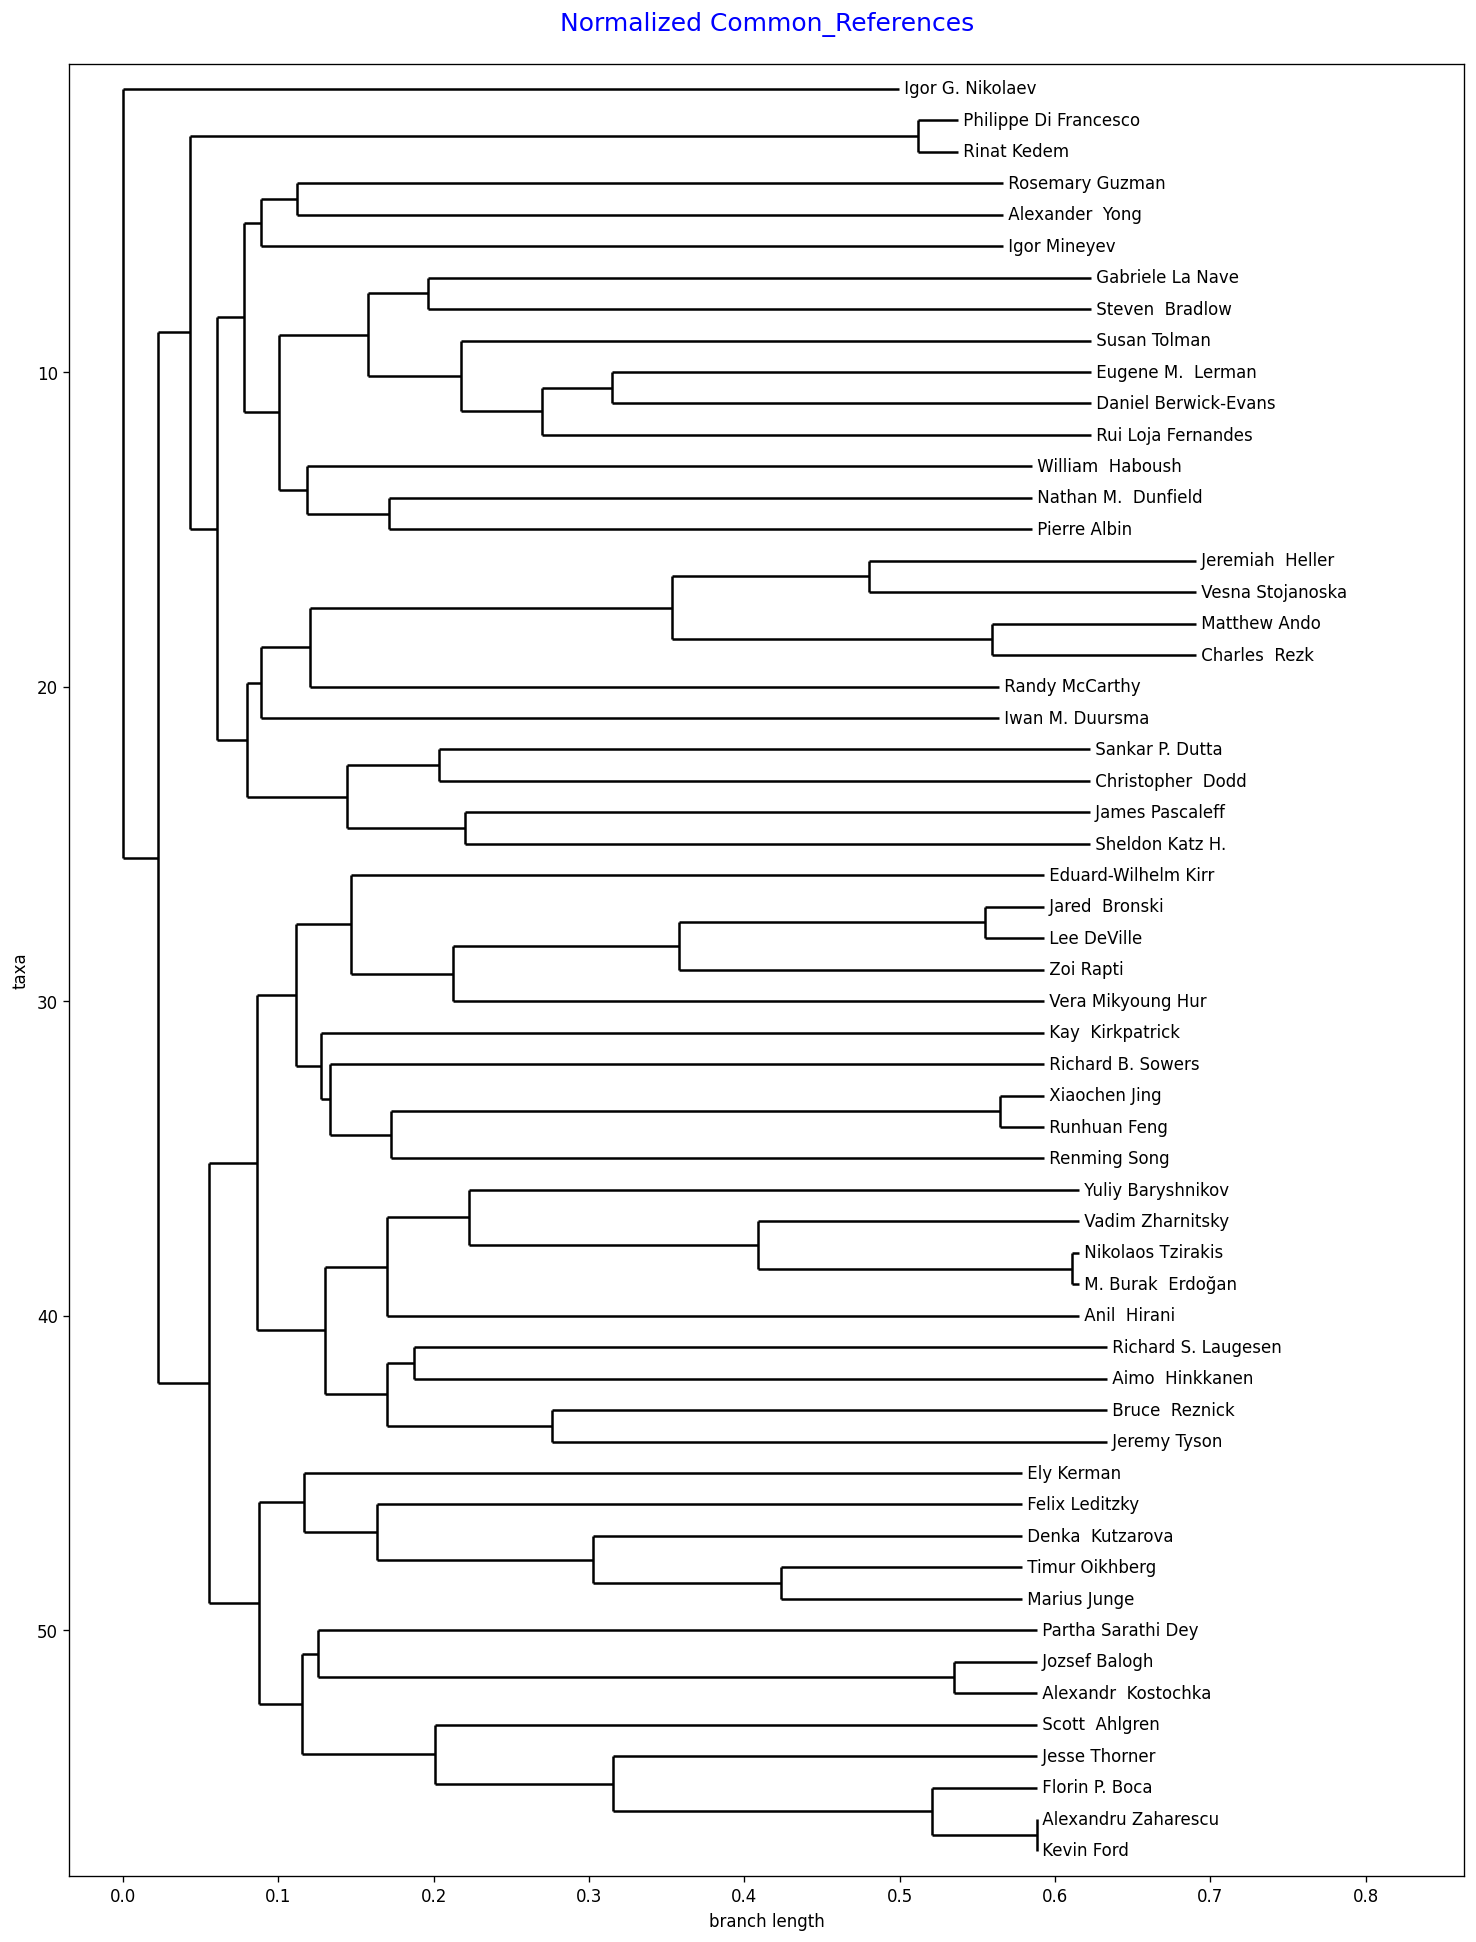

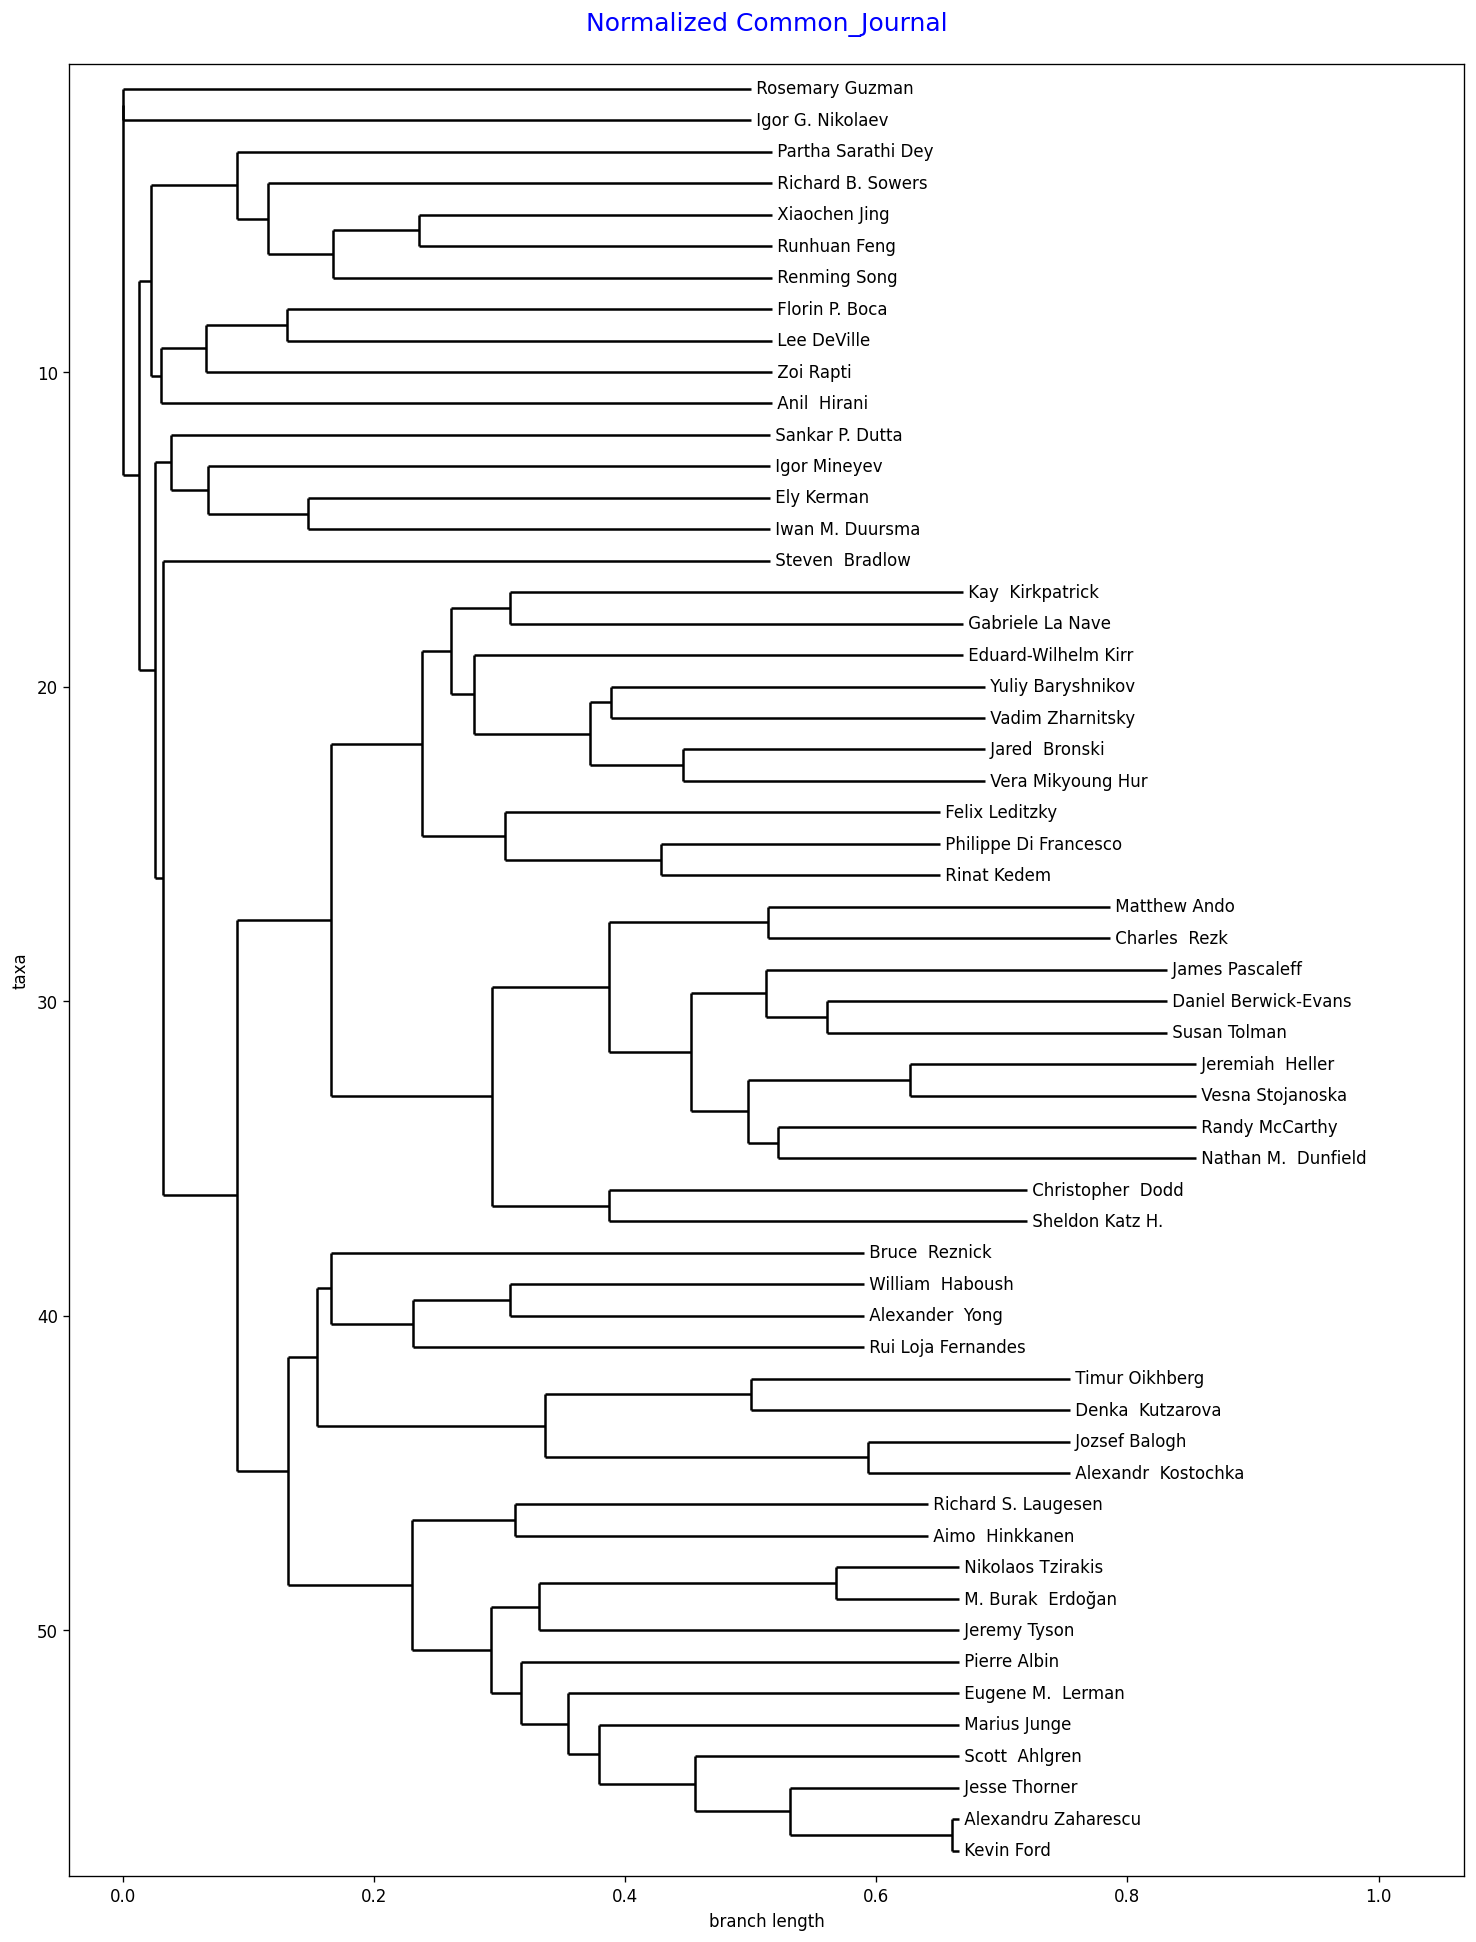

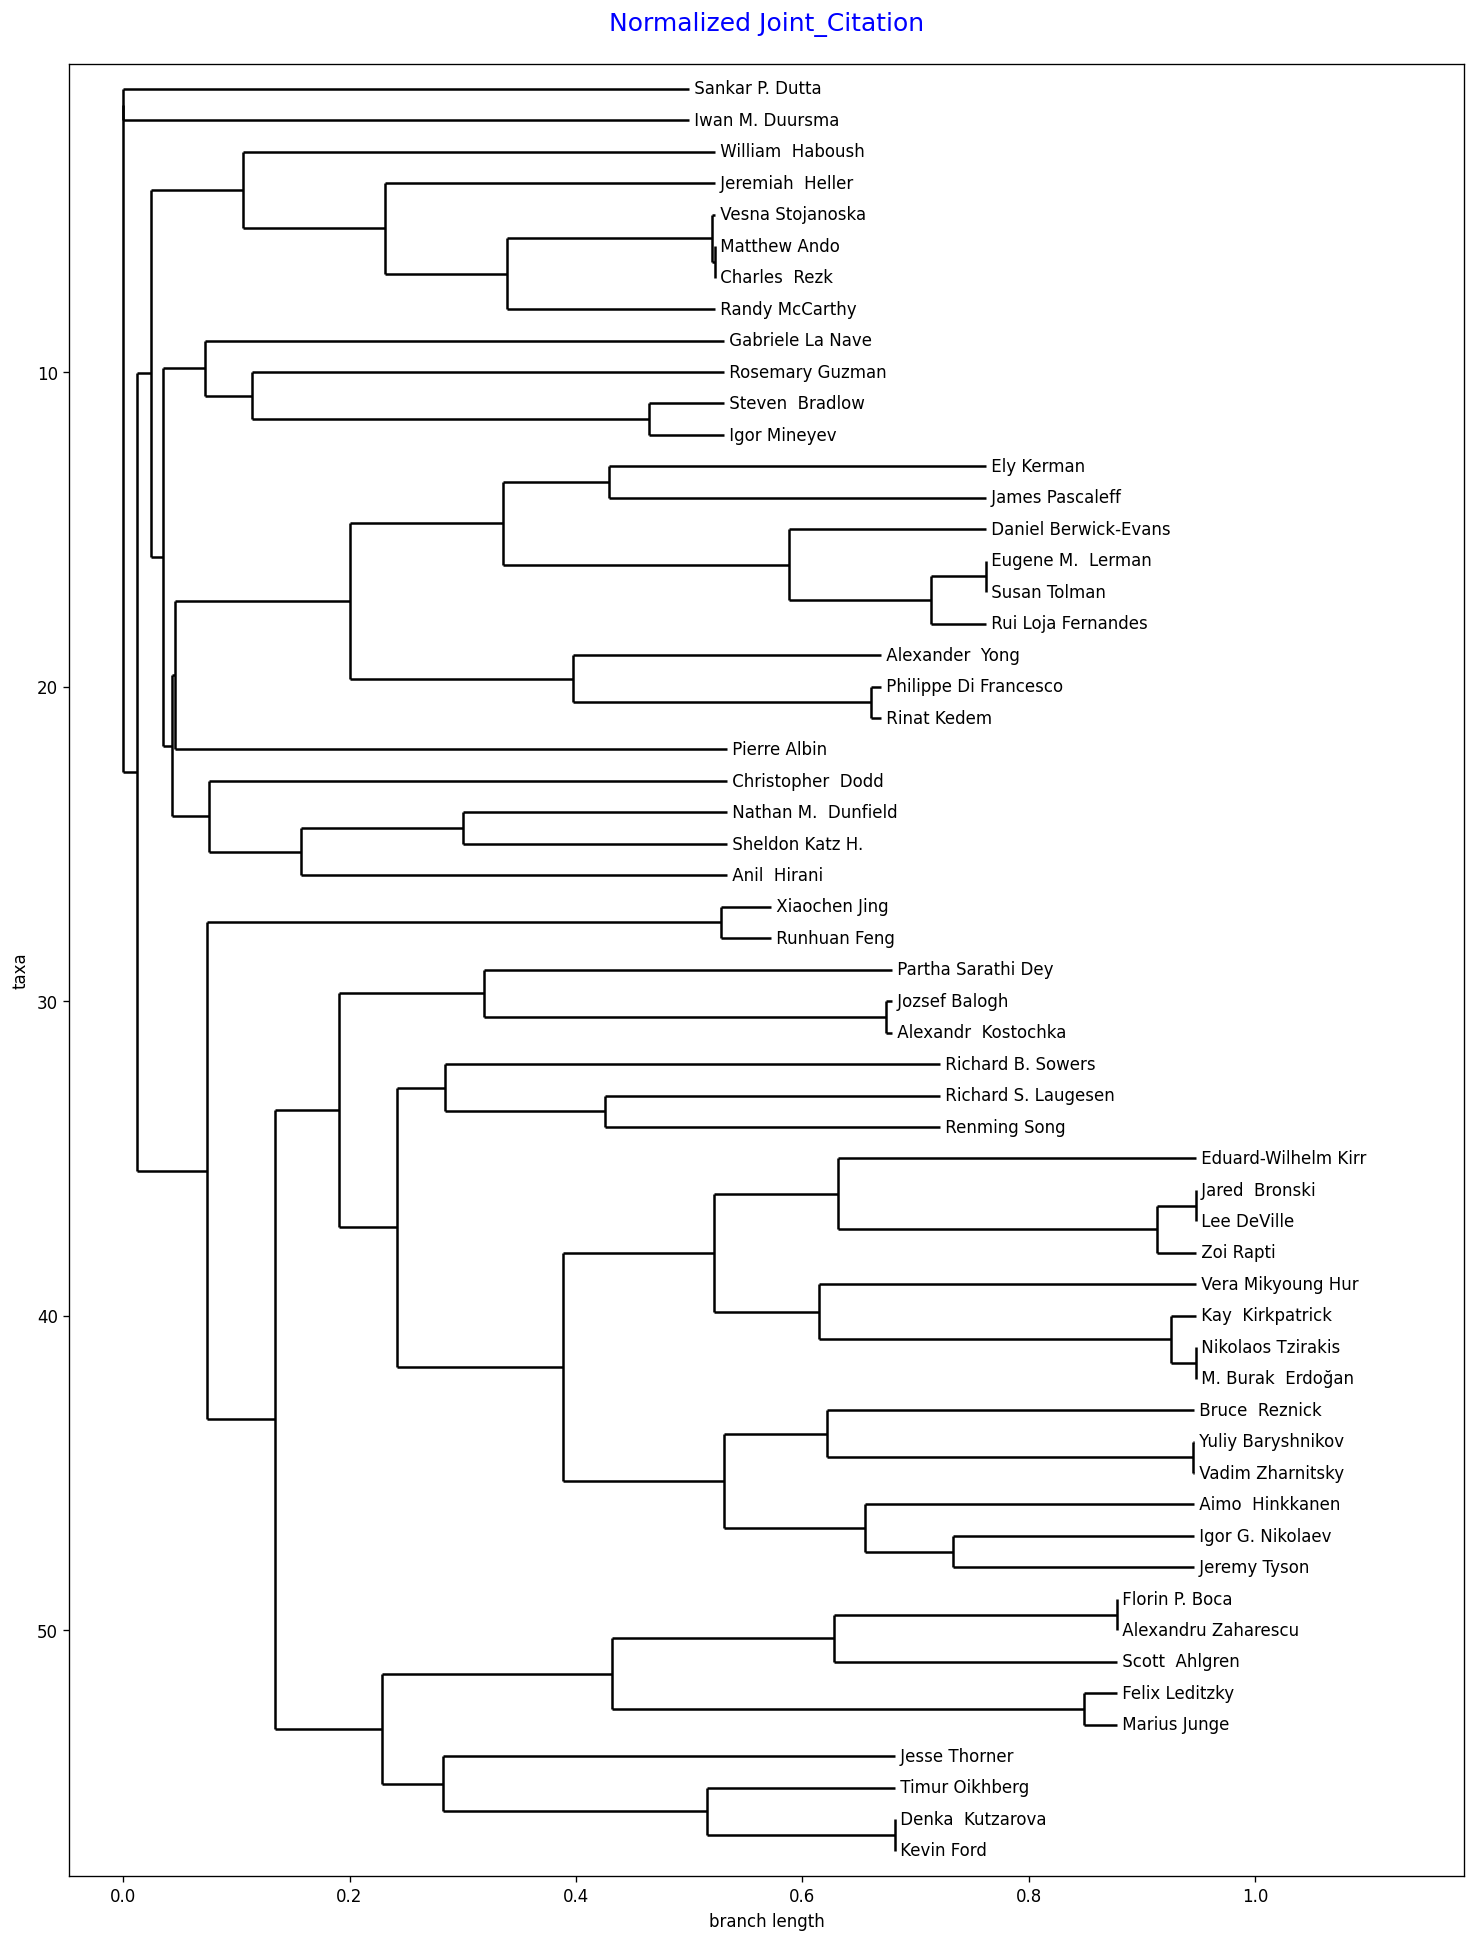

In [98]:
phylo_dmatrices = []
for item in to_normalize:
    sim = item["data"]
    phylo_dmatrices.append(phylo_dmatrix_from_numpy(faculties, d1(sim, r=1.5)))

phylo_trees = []
for dmat in phylo_dmatrices:
    phylo_trees.append(upgma(dmat))

for i in range(len(phylo_trees)):
    tree = phylo_trees[i]
    name = to_normalize[i]["Name"]
    
    fig = plt.figure(figsize=(15, 20), dpi=120)
    axes = fig.add_subplot(1, 1, 1)
    fontdic = {'fontsize': 15, 'color':  'blue'}
    axes.set_title("Normalized " + name, fontdict=fontdic, pad=20)

    Phylo.draw(tree, axes=axes, do_show=False)
    plt.savefig("Normalized_" + name + ".png")
